In [1]:
import numpy as np
import open3d as o3d
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D 

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Data loading

In [26]:
DATA_DIR = 'Data'  # This depends on where this file is located. Change for your needs.

def open_wave_data():
    target = np.load(os.path.join(DATA_DIR, 'wave_target.npy'))
    source = np.load(os.path.join(DATA_DIR, 'wave_source.npy'))
    return source, target

def open_bunny_data():
    target = np.load(os.path.join(DATA_DIR, 'bunny_target.npy'))
    source = np.load(os.path.join(DATA_DIR, 'bunny_source.npy'))
    return source, target

In [125]:
src, dst = open_wave_data()

# Analysing data

In [28]:
src.shape, src[:,0]

((3, 6400), array([-1.43437019, -2.29741086, -0.42440724]))

In [29]:
dst.shape, dst[:,0]

((3, 6400), array([-1.99889667, -1.97539321,  0.37502834]))

In [2]:
%matplotlib notebook
def show_density_map(src, title):
    density = stats.gaussian_kde(src)(src) 

    idx = density.argsort()
    x, y, z, density = src[0][idx], src[1][idx], src[2][idx], density[idx]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=density)
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.4)
    legend2 = ax.legend(handles, labels, loc="upper right", title="density")
    ax.set_title(title)
    plt.show()
    
def plt_1(src, title):
    fig = plt.figure(figsize=(5,5), dpi=80)
    ax2 = fig.add_subplot(111, projection='3d')
    ax2.scatter3D(src[0], src[1], src[2], c=src[2])
    ax2.set_title(title)
    plt.show()

def plt_2(src, dst, title):
    fig = plt.figure(figsize=(5,5), dpi=80)
    ax2 = fig.add_subplot(111, projection='3d')
    ax2.scatter3D(src[0], src[1], src[2], c=src[2], cmap='Greens')
    ax2.scatter3D(dst[0], dst[1], dst[2], c=dst[2], cmap='Blues')
    ax2.set_title(title)
    plt.show()
    
def plt_4(src, src1, dst, title, title1):
    fig = plt.figure(figsize=(5,10), dpi=80)
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.scatter3D(src[0], src[1], src[2], c=src[2], cmap='Greens')
    ax1.scatter3D(dst[0], dst[1], dst[2], c=dst[2], cmap='Blues')
    ax1.set_title(title)
    
    ax2 = fig.add_subplot(212, projection='3d')
    ax2.scatter3D(src1[0], src1[1], src1[2], c=src1[2], cmap='Greens')
    ax2.scatter3D(dst[0], dst[1], dst[2], c=dst[2], cmap='Blues')
    ax2.set_title(title1)
    plt.show()

<IPython.core.display.Javascript object>


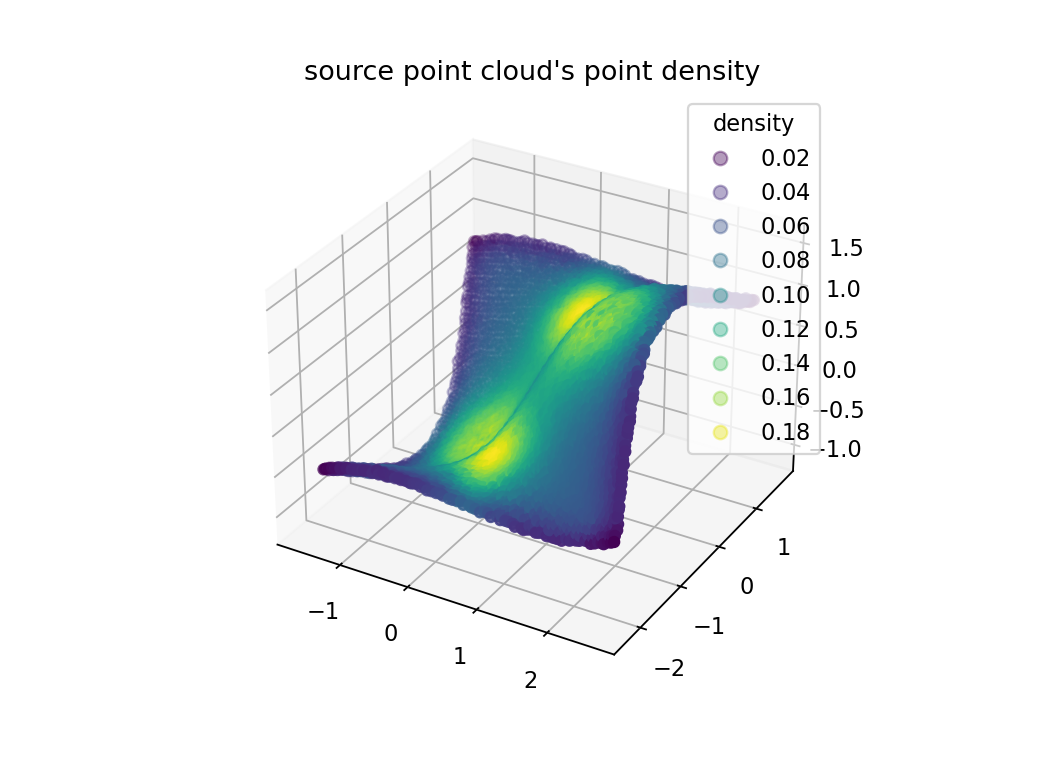

<IPython.core.display.Javascript object>


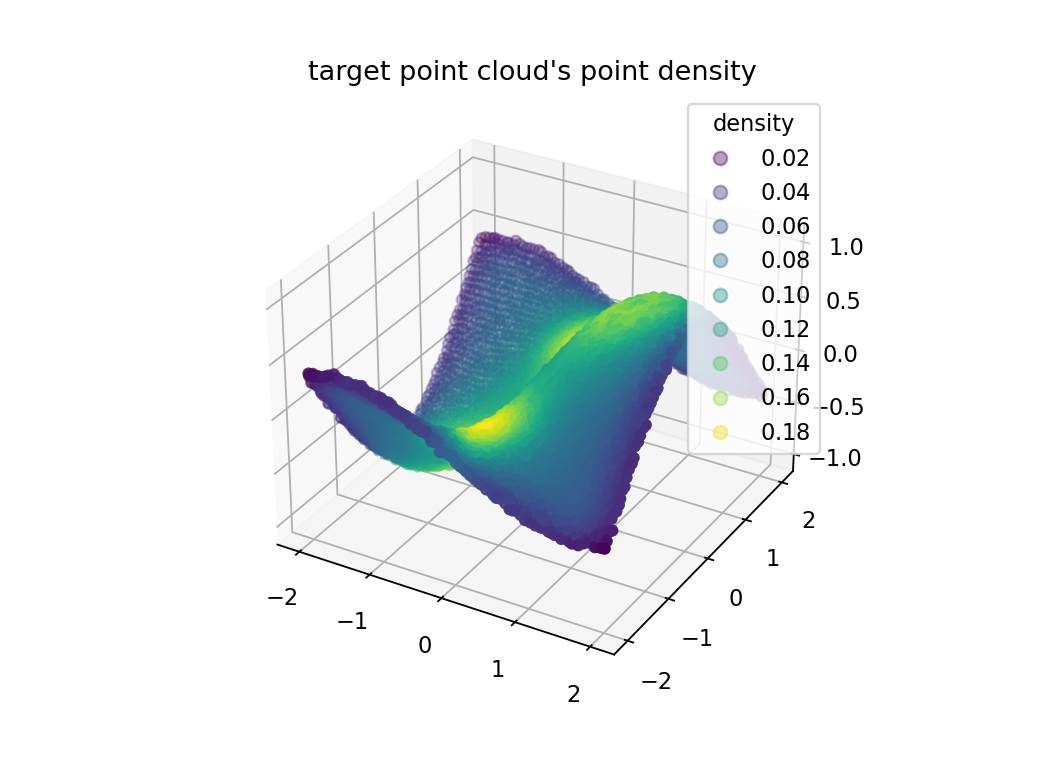

In [43]:
show_density_map(src, "source point cloud's point density")
show_density_map(dst, "target point cloud's point density")

# ICP

In [37]:
def best_fit_transform(A, B, m):

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [102]:
def generate_grid(src, dst, M, N):
    
    src_min = np.min(src, axis=1)
    dst_min = np.min(dst, axis=1)
    src_max = np.max(src, axis=1)
    dst_max = np.max(dst, axis=1)

    x_min = min(src_min[0], dst_min[0])
    x_max = max(src_max[0], dst_max[0])
    y_min = min(src_min[1], dst_min[1])
    y_max = max(src_max[1], dst_max[1])

    x = np.linspace(x_min, x_max, M)
    y = np.linspace(y_min, y_max, N)

    xx, yy = np.meshgrid(x, y, sparse=False)

    return xx, yy

In [160]:
def make_buffer(src,M,N,xx,yy):
    
    src2 = np.copy(src)
    src2[2,:] = src2[2,:] + 500 
    pts_marked = {}
    count = 0
    
    for i in range(M-1):
        for j in range(N-1):
            pts = src2[:,(src2[0, :] < xx[i+1,j+1]) & (src2[1, :] < yy[i+1,j+1]) & (src2[0, :] > xx[i,j]) & (src2[1, :] > yy[i,j])]
            if pts.shape[1]>0:
                count += 1 
                closest_pt = pts[:,np.argmin(pts, axis=1)[2]]
                closest_pt_idx = np.where(np.all(src2==closest_pt.reshape((-1,1)),axis=0))
                pts_marked[(i,j)] = closest_pt_idx
    
    return pts_marked, count

In [161]:
def match_buffers(src_buffer, dst_buffer, src, dst):
    distances, dst_idx = 0,0
    i = 0
    
    for marker in src_buffer:
        if marker in dst_buffer:
            if i==0:
                src_idx = src_buffer[marker][0]
                dst_idx = dst_buffer[marker][0]
                distances = np.array([np.linalg.norm(src[:,src_buffer[marker][0][0]] - dst[:,dst_buffer[marker][0][0]])])
                i = 1
            else:
                src_idx = np.hstack((src_buffer[marker][0][0], src_idx))
                dst_idx = np.hstack((dst_buffer[marker][0][0], dst_idx))
                distances = np.hstack(([np.linalg.norm(src[:,src_buffer[marker][0][0]] - dst[:,dst_buffer[marker][0][0]])], distances))
    
    return distances, dst_idx, src_idx

In [162]:
def match_points(src, dst, matching):
    
    if matching=="zbuffer":
        M, N = 50, 50
        xx, yy = generate_grid(src.T, dst.T, M, N)
        src_buffer, _ = make_buffer(src.T,M,N, xx,yy)
        dst_buffer, _ = make_buffer(dst.T,M,N, xx,yy)
        distances, dst_idx, src_idx = match_buffers(src_buffer, dst_buffer, src.T, dst.T)
        
    elif matching=="kdtree":
        tree = KDTree(dst, leaf_size=2)              
        distances, dst_idx = tree.query(src, k=1)
        
    else:
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(dst)
        distances, dst_idx = neigh.kneighbors(src, return_distance=True)
    
    return distances.ravel(), dst_idx.ravel(), src_idx.ravel()

In [163]:
def sample_1_cloud(A, sampling, step, factor):
    
    if A.shape[1]>200:
        
        if sampling=="uniform":
            A_idx = range(0,A.shape[1],factor) #factor=2
            A = A[:,A_idx]
            
        elif sampling=="random":
            A_idx = np.random.choice(np.arange(0,A.shape[1]), int(A.shape[1]/factor), replace=False) #factor=1.5
            A = A[:, A_idx]
            
        elif sampling=="multi-resolution" and step>3:
            A_idx = np.arange(0,A.shape[1],factor) #factor=30
            if len(np.arange(0,A.shape[1],factor))>100:
                A = A[:,A_idx]
            else:
                A_idx = range(0,A.shape[1])
            
        elif sampling=="point-density":
            m = A.shape[0]
            A_density = stats.gaussian_kde(A[:m-1])(A[:m-1])
            A_idx = A_density.argsort()[int(A.shape[1]/factor):] #fatcor=2
            A = A[:,A_idx]
        
        else:
            A_idx = range(0,A.shape[1])
        
    else:
        A_idx = range(0,A.shape[1])
        
    return A, A_idx
    
def sample_2_cloud(A, B, sampling, step, factor):
    
    if A.shape[1]>300 and B.shape[1]>300:
    
        if sampling=="uniform":
            A_idx = range(0,A.shape[1],factor)
            A = A[:,A_idx]
            B = B[:,range(0,B.shape[1],factor)]

        elif sampling=="random":
            np.random.seed(0)
            A_idx = np.random.choice(np.arange(0,A.shape[1]), int(A.shape[1]/factor), replace=False)
            A = A[:, A_idx]
            B_idx = np.random.choice(np.arange(0,B.shape[1]), int(B.shape[1]/factor), replace=False)
            B = B[:,B_idx]

        elif sampling=="multi-resolution" and step>1:
            A_idx = np.arange(0,A.shape[1],factor)
            if len(np.arange(0,A.shape[1],factor))>100 and len(np.arange(0,B.shape[1],factor))>100:
                A = A[:,A_idx]
                B = B[:,np.arange(0,B.shape[1],factor)]
            else:
                A_idx = range(0,A.shape[1])

        elif sampling=="point-density":
            m = A.shape[0]
            A_density = stats.gaussian_kde(A[:m-1])(A[:m-1])
            A_idx = A_density.argsort()[int(A.shape[1]/factor):]
            A = A[:,A_idx]
            B_density = stats.gaussian_kde(B[:m-1])(B[:m-1])
            B_idx = B_density.argsort()[int(B.shape[1]/factor):]
            B = B[:,B_idx]
            
        else:
            A_idx = range(0,A.shape[1])
            
    else:
        A_idx = range(0,A.shape[1])
            
    return A, B, A_idx

In [164]:
def sample_points(A, B, sampling, sample_on, step, factor=None):
    
    if sample_on=="source":
        A, A_idx = sample_1_cloud(A=A, sampling=sampling, step=step, factor=factor)
    elif sample_on=="target":
        B, _ = sample_1_cloud(A=B, sampling=sampling, step=step, factor=factor)
        A_idx = range(0,A.shape[1])
    else:
        A, B, A_idx = sample_2_cloud(A=A, B=B, sampling=sampling, step=step, factor=factor)
        
    return A, B, A_idx

In [165]:
############################
#     ICP                  #
############################

###### 0. (adding noise)

###### 1. initialize R= I , t= 0

###### go to 2. unless RMS is unchanged(<= epsilon)

###### 2. using different sampling methods

###### 3. transform point cloud with R and t

###### 4. Find the closest point for each point in A1 based on A2 using brute-force approach

###### 5. Calculate RMS

###### 6. Refine R and t using SVD

In [166]:
def icp(A, B, 
        init_pose=None, 
        max_iterations=20, tolerance=0.001, 
        sampling="all", sample_on="both", sampling_factor=2,
        matching="default", 
        noise="off"):
    
    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1, A.shape[0]))
    dst = np.ones((m+1, B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is None:
        init_pose = np.identity(m+1)
        init_pose[:m, :m] = np.identity(m) #R=I
        init_pose[:m, m] = 0 #t=0
    src = np.dot(init_pose, src)
    src1 = np.copy(src)

    prev_rms = 0

    for i in range(max_iterations):
        
        # sample points
        src, dst, src_idx = sample_points(src, dst, sampling, sample_on, step=i, factor=sampling_factor)
        
        if sampling=="multi-resolution" or sampling=="random":
            src1 = src1[:,src_idx]
        elif i==0:
            src1 = src1[:,src_idx]
            
        print("#src pts:", src.shape, "#dst pts:", dst.shape)
        
        # find the nearest neighbors between the current source and destination points
        distances, dst_idx, src_idx = match_points(src[:m,:].T, dst[:m,:].T, matching)

        # compute the transformation between the current source and nearest destination points
        if matching=="zbuffer":
            T,_,_ = best_fit_transform(src[:m,src_idx].T, dst[:m,dst_idx].T, m)
        else:
            T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,dst_idx].T, m)

        # update the current source
        src = np.dot(T, src)

        # check error
        new_rms = np.sqrt(np.mean(distances**2))
        
        if np.abs(prev_rms - new_rms) < tolerance:
            print(f"break at iteration{i}: prev_error={prev_rms} rms={new_rms}")
            break
        elif i!=max_iterations-1:
            print(f"iteration{i}: prev_error={prev_rms} rms={new_rms}")
            prev_rms = new_rms
        else:
            print(f"iteration{i}: prev_error={prev_rms} rms={new_rms}")
  
    # calculate final transformation
    T,_,_ = best_fit_transform(src1[:m,:].T, src[:m,:].T, m)

    return T, distances

In [167]:
# try these...
# sample_on: "source", "target", "both"
# sampling: "all", "uniform", "random", "multi-resolution", "point-density"
# mathching: "default", "kdtree", "zbuffer"

T, distances = icp(src.T, dst.T, 
                        init_pose=None, 
                        max_iterations=20, tolerance=0.0001, 
                        sampling="all", sample_on="both", sampling_factor=1.5,
                        matching="zbuffer", 
                        noise="off")

#src pts: (4, 6400) #dst pts: (4, 6400)
iteration0: prev_error=0 rms=0.4596646528829315
#src pts: (4, 6400) #dst pts: (4, 6400)
iteration1: prev_error=0.4596646528829315 rms=0.24845496718527021
#src pts: (4, 6400) #dst pts: (4, 6400)
iteration2: prev_error=0.24845496718527021 rms=0.2320358156283358
#src pts: (4, 6400) #dst pts: (4, 6400)
iteration3: prev_error=0.2320358156283358 rms=0.23130777852006426
#src pts: (4, 6400) #dst pts: (4, 6400)
iteration4: prev_error=0.23130777852006426 rms=0.23094002551471346
#src pts: (4, 6400) #dst pts: (4, 6400)
iteration5: prev_error=0.23094002551471346 rms=0.2304542039273938
#src pts: (4, 6400) #dst pts: (4, 6400)
break at iteration6: prev_error=0.2304542039273938 rms=0.2304273752952697


In [168]:
T

array([[ 0.97729382,  0.00343929,  0.21186069, -0.01260697],
       [-0.06128735,  0.96171779,  0.26710064, -0.00681914],
       [-0.20283156, -0.27402018,  0.94009164, -0.03289823],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [169]:
def apply_icp(src, T):
    
    src1 = np.ones((src.shape[0]+1,src.shape[1]))
    src1[:src.shape[0],:] = np.copy(src)
    src1 = np.dot(T, src1)
    
    return src1[:3,:]

In [170]:
src1 = apply_icp(src, T)

<IPython.core.display.Javascript object>


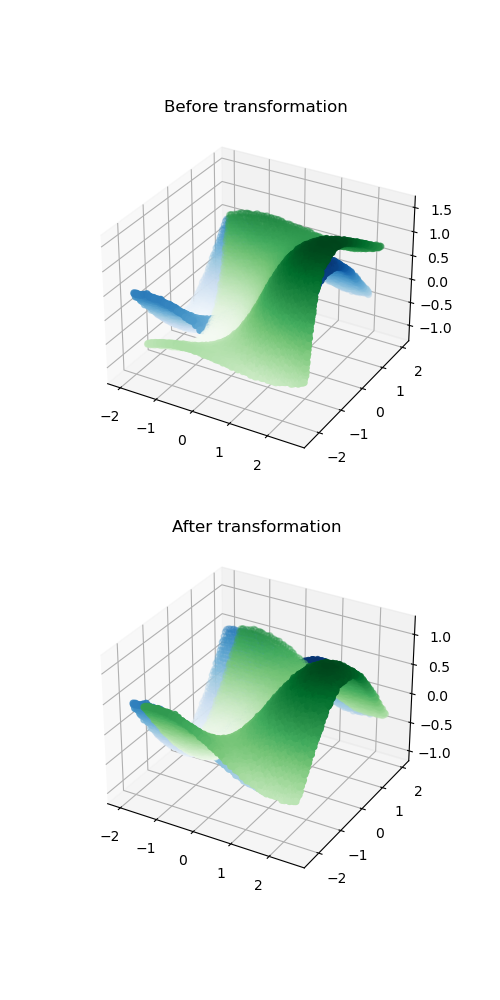

In [171]:
plt_4(src, src1, dst, "Before transformation", "After transformation")

# Combining N frames

In [54]:
def open3d_example():
    pcd = o3d.io.read_point_cloud("Data/data/0000000099.pcd")
    # ## convert into ndarray

    pcd_arr = np.asarray(pcd.points)

    # ***  you need to clean the point cloud using a threshold ***
    pcd_cleaned = pcd_arr[pcd_arr[:, 2] < 2]

    # visualization from ndarray
    vis_pcd = o3d.geometry.PointCloud()
    vis_pcd.points = o3d.utility.Vector3dVector(pcd_cleaned)
    o3d.visualization.draw_geometries([vis_pcd])

In [55]:
# open3d_example()

In [10]:
pcd_arr = []

for i in range(100):
    pcd = o3d.io.read_point_cloud(f"Data/data/00000000{i:02}.pcd")
    pcd = np.asarray(pcd.points)
    pcd = pcd[pcd[:, 2] < 2]
    pcd_arr.append(pcd.T)

pcd_arr[0].shape

(3, 67133)

In [17]:
### 3.1

def get_merged_pcd_3_1(N):
    pcd_idx = list(range(0, len(pcd_arr)-1, N))

    T_collection = []

    for i in range(0, len(pcd_idx)-1):

        print(f"for pcds {pcd_idx[i]},{pcd_idx[i+1]}:", "\n")
        T, distances = icp(pcd_arr[pcd_idx[i]].T, pcd_arr[pcd_idx[i+1]].T, 
                                init_pose=None, 
                                max_iterations=100, tolerance=0.0001, 
                                sampling="multi-resolution", sample_on="both", sampling_factor=30,
                                matching="kdtree", 
                                noise="off")

        T_collection.append(T)
        print("\n")

    merged_pcd_3_1 = pcd_arr[-1]

    for i in range(0, len(pcd_idx)-1): 
        pcd = pcd_arr[pcd_idx[i]]

        for T in T_collection[i:]:
            pcd = apply_icp(pcd, T)

        merged_pcd_3_1 = np.hstack((pcd, merged_pcd_3_1))
        
    return merged_pcd_3_1

In [38]:
merged_pcd_3_1_1 = get_merged_pcd_3_1(N=1)

for pcds 0,1: 

#src pts: (4, 67133) #dst pts: (4, 67089)
iteration0: prev_error=0 rms=0.00408424621745951
#src pts: (4, 67133) #dst pts: (4, 67089)
iteration1: prev_error=0.00408424621745951 rms=0.0024632298793809274
#src pts: (4, 1679) #dst pts: (4, 1678)
iteration2: prev_error=0.0024632298793809274 rms=0.005867668377987842
#src pts: (4, 42) #dst pts: (4, 42)
iteration3: prev_error=0.005867668377987842 rms=0.03713899907636272
#src pts: (4, 42) #dst pts: (4, 42)
iteration4: prev_error=0.03713899907636272 rms=0.03469660656394957
#src pts: (4, 42) #dst pts: (4, 42)
iteration5: prev_error=0.03469660656394957 rms=0.03417848487456368
#src pts: (4, 42) #dst pts: (4, 42)
break at iteration6: prev_error=0.03417848487456368 rms=0.03417848487456367


for pcds 1,2: 

#src pts: (4, 67089) #dst pts: (4, 66412)
iteration0: prev_error=0 rms=0.0069190882019051
#src pts: (4, 67089) #dst pts: (4, 66412)
iteration1: prev_error=0.0069190882019051 rms=0.003692065278073976
#src pts: (4, 1678) #dst pts: (4,

iteration0: prev_error=0 rms=0.007771143322177018
#src pts: (4, 57420) #dst pts: (4, 56449)
iteration1: prev_error=0.007771143322177018 rms=0.004463331667126245
#src pts: (4, 1436) #dst pts: (4, 1412)
iteration2: prev_error=0.004463331667126245 rms=0.008449564132195221
#src pts: (4, 36) #dst pts: (4, 36)
iteration3: prev_error=0.008449564132195221 rms=0.04783327710841809
#src pts: (4, 36) #dst pts: (4, 36)
iteration4: prev_error=0.04783327710841809 rms=0.04717243691394538
#src pts: (4, 36) #dst pts: (4, 36)
break at iteration5: prev_error=0.04717243691394538 rms=0.04712027147032433


for pcds 12,13: 

#src pts: (4, 56449) #dst pts: (4, 53206)
iteration0: prev_error=0 rms=0.005382958569075318
#src pts: (4, 56449) #dst pts: (4, 53206)
iteration1: prev_error=0.005382958569075318 rms=0.003997630620574443
#src pts: (4, 1412) #dst pts: (4, 1331)
iteration2: prev_error=0.003997630620574443 rms=0.008275743693462262
#src pts: (4, 36) #dst pts: (4, 34)
iteration3: prev_error=0.008275743693462262

KeyboardInterrupt: 

In [67]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_1_1.T)
o3d.visualization.draw_geometries([vis_pcd])

<IPython.core.display.Javascript object>


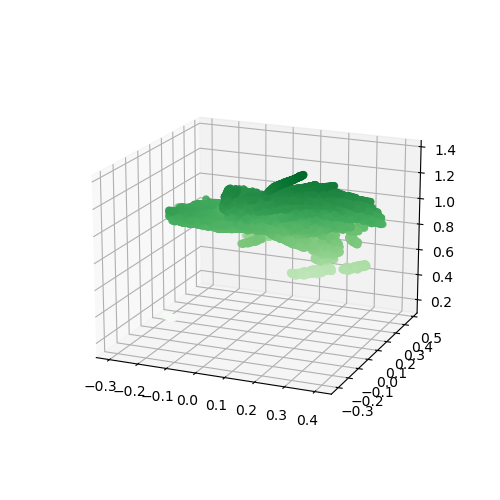

In [76]:
plt_1(merged_pcd_3_1_1, "3.1 merged_pcd")

In [18]:
merged_pcd_3_1_2 = get_merged_pcd_3_1(N=2)

for pcds 0,2: 

#src pts: (4, 67133) #dst pts: (4, 66412)
iteration0: prev_error=0 rms=0.01076374440411733
#src pts: (4, 67133) #dst pts: (4, 66412)
iteration1: prev_error=0.01076374440411733 rms=0.005460884034979697
#src pts: (4, 2238) #dst pts: (4, 2214)
iteration2: prev_error=0.005460884034979697 rms=0.007249943679333749
#src pts: (4, 2238) #dst pts: (4, 2214)
iteration3: prev_error=0.007249943679333749 rms=0.006868576470641624
#src pts: (4, 2238) #dst pts: (4, 2214)
iteration4: prev_error=0.006868576470641624 rms=0.0067318057571989
#src pts: (4, 2238) #dst pts: (4, 2214)
break at iteration5: prev_error=0.0067318057571989 rms=0.006650099293257383


for pcds 2,4: 

#src pts: (4, 66412) #dst pts: (4, 65877)
iteration0: prev_error=0 rms=0.00794566047660403
#src pts: (4, 66412) #dst pts: (4, 65877)
iteration1: prev_error=0.00794566047660403 rms=0.00441251686064272
#src pts: (4, 2214) #dst pts: (4, 2196)
iteration2: prev_error=0.00441251686064272 rms=0.007413527008310944
#src pts: (4, 22

iteration0: prev_error=0 rms=0.02290398962313757
#src pts: (4, 41152) #dst pts: (4, 36433)
iteration1: prev_error=0.02290398962313757 rms=0.021691252315812495
#src pts: (4, 1372) #dst pts: (4, 1215)
iteration2: prev_error=0.021691252315812495 rms=0.022473220823104382
#src pts: (4, 1372) #dst pts: (4, 1215)
iteration3: prev_error=0.022473220823104382 rms=0.022094003670864334
#src pts: (4, 1372) #dst pts: (4, 1215)
iteration4: prev_error=0.022094003670864334 rms=0.021879733149746505
#src pts: (4, 1372) #dst pts: (4, 1215)
iteration5: prev_error=0.021879733149746505 rms=0.021744624629241045
#src pts: (4, 1372) #dst pts: (4, 1215)
break at iteration6: prev_error=0.021744624629241045 rms=0.02167297169477879


for pcds 22,24: 

#src pts: (4, 36433) #dst pts: (4, 38847)
iteration0: prev_error=0 rms=0.022598353584747537
#src pts: (4, 36433) #dst pts: (4, 38847)
iteration1: prev_error=0.022598353584747537 rms=0.0216947145834035
#src pts: (4, 1215) #dst pts: (4, 1295)
break at iteration2: prev_e

iteration0: prev_error=0 rms=0.008279358225264911
#src pts: (4, 57821) #dst pts: (4, 59205)
iteration1: prev_error=0.008279358225264911 rms=0.004057413592691783
#src pts: (4, 1928) #dst pts: (4, 1974)
iteration2: prev_error=0.004057413592691783 rms=0.00754820216764828
#src pts: (4, 1928) #dst pts: (4, 1974)
iteration3: prev_error=0.00754820216764828 rms=0.0073894252857345894
#src pts: (4, 1928) #dst pts: (4, 1974)
break at iteration4: prev_error=0.0073894252857345894 rms=0.007313916279877477


for pcds 40,42: 

#src pts: (4, 59205) #dst pts: (4, 60748)
iteration0: prev_error=0 rms=0.008068414445352409
#src pts: (4, 59205) #dst pts: (4, 60748)
iteration1: prev_error=0.008068414445352409 rms=0.0035251634995840143
#src pts: (4, 1974) #dst pts: (4, 2025)
iteration2: prev_error=0.0035251634995840143 rms=0.007047608855577007
#src pts: (4, 1974) #dst pts: (4, 2025)
break at iteration3: prev_error=0.007047608855577007 rms=0.00696265246359866


for pcds 42,44: 

#src pts: (4, 60748) #dst pts: (

iteration1: prev_error=0.006427443075262034 rms=0.004516705480256968
#src pts: (4, 1819) #dst pts: (4, 1756)
iteration2: prev_error=0.004516705480256968 rms=0.007025978567424169
#src pts: (4, 1819) #dst pts: (4, 1756)
iteration3: prev_error=0.007025978567424169 rms=0.00679101292565132
#src pts: (4, 1819) #dst pts: (4, 1756)
iteration4: prev_error=0.00679101292565132 rms=0.0066748017237617235
#src pts: (4, 1819) #dst pts: (4, 1756)
break at iteration5: prev_error=0.0066748017237617235 rms=0.006599832932035115


for pcds 64,66: 

#src pts: (4, 52676) #dst pts: (4, 49572)
iteration0: prev_error=0 rms=0.009618146279553019
#src pts: (4, 52676) #dst pts: (4, 49572)
iteration1: prev_error=0.009618146279553019 rms=0.006807100512717173
#src pts: (4, 1756) #dst pts: (4, 1653)
iteration2: prev_error=0.006807100512717173 rms=0.008656887918647325
#src pts: (4, 1756) #dst pts: (4, 1653)
iteration3: prev_error=0.008656887918647325 rms=0.008182759986255606
#src pts: (4, 1756) #dst pts: (4, 1653)
itera

iteration0: prev_error=0 rms=0.01506441216747376
#src pts: (4, 43564) #dst pts: (4, 48245)
iteration1: prev_error=0.01506441216747376 rms=0.012854901731097625
#src pts: (4, 1453) #dst pts: (4, 1609)
iteration2: prev_error=0.012854901731097625 rms=0.01643992963899071
#src pts: (4, 1453) #dst pts: (4, 1609)
iteration3: prev_error=0.01643992963899071 rms=0.01628210109496392
#src pts: (4, 1453) #dst pts: (4, 1609)
break at iteration4: prev_error=0.01628210109496392 rms=0.016224189087813156


for pcds 84,86: 

#src pts: (4, 48245) #dst pts: (4, 53505)
iteration0: prev_error=0 rms=0.012248871402628623
#src pts: (4, 48245) #dst pts: (4, 53505)
iteration1: prev_error=0.012248871402628623 rms=0.007966602605517834
#src pts: (4, 1609) #dst pts: (4, 1784)
iteration2: prev_error=0.007966602605517834 rms=0.009028272827411938
#src pts: (4, 1609) #dst pts: (4, 1784)
iteration3: prev_error=0.009028272827411938 rms=0.008059117870788883
#src pts: (4, 1609) #dst pts: (4, 1784)
iteration4: prev_error=0.008

In [19]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_1_2.T)
o3d.visualization.draw_geometries([vis_pcd])

In [15]:
merged_pcd_3_1_4 = get_merged_pcd_3_1(N=4)

for pcds 0,4: 

#src pts: (4, 67133) #dst pts: (4, 65877)
iteration0: prev_error=0 rms=0.018226924610631853
#src pts: (4, 67133) #dst pts: (4, 65877)
iteration1: prev_error=0.018226924610631853 rms=0.009029730297771212
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration2: prev_error=0.009029730297771212 rms=0.010763935324269773
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration3: prev_error=0.010763935324269773 rms=0.009994121551342222
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration4: prev_error=0.009994121551342222 rms=0.009651227485783894
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration5: prev_error=0.009651227485783894 rms=0.009390767963591028
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration6: prev_error=0.009390767963591028 rms=0.009167780234156557
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration7: prev_error=0.009167780234156557 rms=0.008979737647627993
#src pts: (4, 1679) #dst pts: (4, 1647)
iteration8: prev_error=0.008979737647627993 rms=0.008824341291402036
#src pts: (4, 1679

iteration1: prev_error=0.023389071475663357 rms=0.012257864031594278
#src pts: (4, 972) #dst pts: (4, 1108)
iteration2: prev_error=0.012257864031594278 rms=0.012825974902010926
#src pts: (4, 972) #dst pts: (4, 1108)
iteration3: prev_error=0.012825974902010926 rms=0.012233602922327882
#src pts: (4, 972) #dst pts: (4, 1108)
iteration4: prev_error=0.012233602922327882 rms=0.01174500690206205
#src pts: (4, 972) #dst pts: (4, 1108)
iteration5: prev_error=0.01174500690206205 rms=0.011286770845237477
#src pts: (4, 972) #dst pts: (4, 1108)
iteration6: prev_error=0.011286770845237477 rms=0.010780309973340759
#src pts: (4, 972) #dst pts: (4, 1108)
iteration7: prev_error=0.010780309973340759 rms=0.010324376991837076
#src pts: (4, 972) #dst pts: (4, 1108)
iteration8: prev_error=0.010324376991837076 rms=0.00997531125698603
#src pts: (4, 972) #dst pts: (4, 1108)
iteration9: prev_error=0.00997531125698603 rms=0.009646177462564198
#src pts: (4, 972) #dst pts: (4, 1108)
iteration10: prev_error=0.009646

iteration0: prev_error=0 rms=0.015179556521902652
#src pts: (4, 61016) #dst pts: (4, 61183)
iteration1: prev_error=0.015179556521902652 rms=0.006569400586656192
#src pts: (4, 1526) #dst pts: (4, 1530)
iteration2: prev_error=0.006569400586656192 rms=0.008413325941529543
#src pts: (4, 1526) #dst pts: (4, 1530)
iteration3: prev_error=0.008413325941529543 rms=0.008133277891615002
#src pts: (4, 1526) #dst pts: (4, 1530)
break at iteration4: prev_error=0.008133277891615002 rms=0.008071438759721002


for pcds 52,56: 

#src pts: (4, 61183) #dst pts: (4, 58972)
iteration0: prev_error=0 rms=0.01841489448777044
#src pts: (4, 61183) #dst pts: (4, 58972)
iteration1: prev_error=0.01841489448777044 rms=0.00941274071335647
#src pts: (4, 1530) #dst pts: (4, 1475)
iteration2: prev_error=0.00941274071335647 rms=0.012236216465956564
#src pts: (4, 1530) #dst pts: (4, 1475)
iteration3: prev_error=0.012236216465956564 rms=0.011803718599153277
#src pts: (4, 1530) #dst pts: (4, 1475)
iteration4: prev_error=0.0

iteration0: prev_error=0 rms=0.018882448134085104
#src pts: (4, 55253) #dst pts: (4, 61523)
iteration1: prev_error=0.018882448134085104 rms=0.009403608858212408
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration2: prev_error=0.009403608858212408 rms=0.010221357404798011
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration3: prev_error=0.010221357404798011 rms=0.009617564982291445
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration4: prev_error=0.009617564982291445 rms=0.009236438192222618
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration5: prev_error=0.009236438192222618 rms=0.008880750462104056
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration6: prev_error=0.008880750462104056 rms=0.00855014653367042
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration7: prev_error=0.00855014653367042 rms=0.008250531229732013
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration8: prev_error=0.008250531229732013 rms=0.008011754299315341
#src pts: (4, 1382) #dst pts: (4, 1539)
iteration9: prev_error=0.0080117542993

In [16]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_1_4.T)
o3d.visualization.draw_geometries([vis_pcd])

In [13]:
merged_pcd_3_1_10 = get_merged_pcd_3_1(N=10)

for pcds 0,10: 

#src pts: (4, 67133) #dst pts: (4, 59813)
iteration0: prev_error=0 rms=0.046661458963178915
#src pts: (4, 67133) #dst pts: (4, 59813)
iteration1: prev_error=0.046661458963178915 rms=0.019013645276976965
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration2: prev_error=0.019013645276976965 rms=0.017937333715648505
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration3: prev_error=0.017937333715648505 rms=0.016354849665025036
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration4: prev_error=0.016354849665025036 rms=0.015563809502904544
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration5: prev_error=0.015563809502904544 rms=0.015162705333880139
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration6: prev_error=0.015162705333880139 rms=0.014855130769042081
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration7: prev_error=0.014855130769042081 rms=0.014586562652567655
#src pts: (4, 1679) #dst pts: (4, 1496)
iteration8: prev_error=0.014586562652567655 rms=0.014399677234176825
#src pts: (4, 167

#src pts: (4, 1481) #dst pts: (4, 1531)
iteration25: prev_error=0.01213028410137672 rms=0.011886424901305023
#src pts: (4, 1481) #dst pts: (4, 1531)
iteration26: prev_error=0.011886424901305023 rms=0.011652277350348982
#src pts: (4, 1481) #dst pts: (4, 1531)
iteration27: prev_error=0.011652277350348982 rms=0.01145782524835477
#src pts: (4, 1481) #dst pts: (4, 1531)
iteration28: prev_error=0.01145782524835477 rms=0.011284450174139168
#src pts: (4, 1481) #dst pts: (4, 1531)
iteration29: prev_error=0.011284450174139168 rms=0.011145913318860832
#src pts: (4, 1481) #dst pts: (4, 1531)
iteration30: prev_error=0.011145913318860832 rms=0.011032668962044648
#src pts: (4, 1481) #dst pts: (4, 1531)
break at iteration31: prev_error=0.011032668962044648 rms=0.010959453844373978


for pcds 50,60: 

#src pts: (4, 61237) #dst pts: (4, 56362)
iteration0: prev_error=0 rms=0.04116618255729138
#src pts: (4, 61237) #dst pts: (4, 56362)
iteration1: prev_error=0.04116618255729138 rms=0.019096359815478317
#sr

In [14]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_1_10.T)
o3d.visualization.draw_geometries([vis_pcd])

In [21]:
### 3.2

def get_merged_pcd_3_2(N):
    pcd_idx = list(range(0, len(pcd_arr)-1, N))

    merged_pcd_3_2 = pcd_arr[0]

    for i in range(0, len(pcd_idx)-1): 
        print(f"for pcds {pcd_idx[i]},{pcd_idx[i+1]}:", "\n")
        T, distances = icp(merged_pcd_3_2.T, pcd_arr[pcd_idx[i+1]].T, 
                                init_pose=None, 
                                max_iterations=100, tolerance=0.0001, 
                                sampling="multi-resolution", sample_on="both", sampling_factor=30+i,
                                matching="kdtree", 
                                noise="off")

        new_pcd = apply_icp(merged_pcd_3_2, T)
        merged_pcd_3_2 = np.hstack((new_pcd, pcd_arr[i+1]))
        print("\n")
    
    return merged_pcd_3_2

In [55]:
merged_pcd_3_2_1 = get_merged_pcd_3_2(N=1)

for pcds 0,1: 

#src pts: (4, 67133) #dst pts: (4, 67089)
iteration0: prev_error=0 rms=0.00408424621745951
#src pts: (4, 67133) #dst pts: (4, 67089)
iteration1: prev_error=0.00408424621745951 rms=0.0024632298793809274
#src pts: (4, 2238) #dst pts: (4, 2237)
iteration2: prev_error=0.0024632298793809274 rms=0.005803994842317379
#src pts: (4, 2238) #dst pts: (4, 2237)
iteration3: prev_error=0.005803994842317379 rms=0.005641946570146997
#src pts: (4, 2238) #dst pts: (4, 2237)
break at iteration4: prev_error=0.005641946570146997 rms=0.005564553831036439


for pcds 1,2: 

#src pts: (4, 134222) #dst pts: (4, 66412)
iteration0: prev_error=0 rms=0.007115637216533444
#src pts: (4, 134222) #dst pts: (4, 66412)
iteration1: prev_error=0.007115637216533444 rms=0.0039210095250286426
#src pts: (4, 4330) #dst pts: (4, 2143)
iteration2: prev_error=0.0039210095250286426 rms=0.006594859242441663
#src pts: (4, 4330) #dst pts: (4, 2143)
iteration3: prev_error=0.006594859242441663 rms=0.006388902463531967
#s



for pcds 14,15: 

#src pts: (4, 927371) #dst pts: (4, 51376)
iteration0: prev_error=0 rms=0.009113702259714257
#src pts: (4, 927371) #dst pts: (4, 51376)
iteration1: prev_error=0.009113702259714257 rms=0.008124965134966952
#src pts: (4, 21077) #dst pts: (4, 1168)
iteration2: prev_error=0.008124965134966952 rms=0.011986101645047995
#src pts: (4, 21077) #dst pts: (4, 1168)
iteration3: prev_error=0.011986101645047995 rms=0.011847801577210996
#src pts: (4, 21077) #dst pts: (4, 1168)
break at iteration4: prev_error=0.011847801577210996 rms=0.011767027119599188


for pcds 15,16: 

#src pts: (4, 978747) #dst pts: (4, 50041)
iteration0: prev_error=0 rms=0.010924996292303965
#src pts: (4, 978747) #dst pts: (4, 50041)
iteration1: prev_error=0.010924996292303965 rms=0.010215589777265145
#src pts: (4, 21750) #dst pts: (4, 1113)
iteration2: prev_error=0.010215589777265145 rms=0.014232876276473284
#src pts: (4, 21750) #dst pts: (4, 1113)
iteration3: prev_error=0.014232876276473284 rms=0.0141152238

iteration11: prev_error=0.0689594368173034 rms=0.06865492504541594
#src pts: (4, 25463) #dst pts: (4, 736)
iteration12: prev_error=0.06865492504541594 rms=0.06837957017581345
#src pts: (4, 25463) #dst pts: (4, 736)
iteration13: prev_error=0.06837957017581345 rms=0.06812275770333026
#src pts: (4, 25463) #dst pts: (4, 736)
iteration14: prev_error=0.06812275770333026 rms=0.06784473942994682
#src pts: (4, 25463) #dst pts: (4, 736)
iteration15: prev_error=0.06784473942994682 rms=0.06751923607546743
#src pts: (4, 25463) #dst pts: (4, 736)
iteration16: prev_error=0.06751923607546743 rms=0.06708684157028753
#src pts: (4, 25463) #dst pts: (4, 736)
iteration17: prev_error=0.06708684157028753 rms=0.06644189401455962
#src pts: (4, 25463) #dst pts: (4, 736)
iteration18: prev_error=0.06644189401455962 rms=0.06555608006866472
#src pts: (4, 25463) #dst pts: (4, 736)
iteration19: prev_error=0.06555608006866472 rms=0.06437932393953012
#src pts: (4, 25463) #dst pts: (4, 736)
iteration20: prev_error=0.064



for pcds 38,39: 

#src pts: (4, 2055482) #dst pts: (4, 58255)
iteration0: prev_error=0 rms=0.02976555590077581
#src pts: (4, 2055482) #dst pts: (4, 58255)
iteration1: prev_error=0.02976555590077581 rms=0.029564141200069442
#src pts: (4, 30228) #dst pts: (4, 857)
iteration2: prev_error=0.029564141200069442 rms=0.032834459039024884
#src pts: (4, 30228) #dst pts: (4, 857)
break at iteration3: prev_error=0.032834459039024884 rms=0.03281570314274761


for pcds 39,40: 

#src pts: (4, 2113737) #dst pts: (4, 59205)
iteration0: prev_error=0 rms=0.029294063562370482
#src pts: (4, 2113737) #dst pts: (4, 59205)
iteration1: prev_error=0.029294063562370482 rms=0.02906046292406164
#src pts: (4, 30634) #dst pts: (4, 859)
iteration2: prev_error=0.02906046292406164 rms=0.032719191541516875
#src pts: (4, 30634) #dst pts: (4, 859)
break at iteration3: prev_error=0.032719191541516875 rms=0.0326939481688045


for pcds 40,41: 

#src pts: (4, 2172942) #dst pts: (4, 59401)
iteration0: prev_error=0 rms=0.0288

iteration1: prev_error=0.026579853616111537 rms=0.02635974637616586
#src pts: (4, 36561) #dst pts: (4, 677)
iteration2: prev_error=0.02635974637616586 rms=0.03019623756672591
#src pts: (4, 36561) #dst pts: (4, 677)
break at iteration3: prev_error=0.03019623756672591 rms=0.03017226334088737


for pcds 57,58: 

#src pts: (4, 3202338) #dst pts: (4, 57488)
iteration0: prev_error=0 rms=0.026633953810558247
#src pts: (4, 3202338) #dst pts: (4, 57488)
iteration1: prev_error=0.026633953810558247 rms=0.026293454261856513
#src pts: (4, 36809) #dst pts: (4, 661)
iteration2: prev_error=0.026293454261856513 rms=0.03019290986442099
#src pts: (4, 36809) #dst pts: (4, 661)
break at iteration3: prev_error=0.03019290986442099 rms=0.030141542562491592


for pcds 58,59: 

#src pts: (4, 3259826) #dst pts: (4, 57077)
iteration0: prev_error=0 rms=0.02624157022386674
#src pts: (4, 3259826) #dst pts: (4, 57077)
iteration1: prev_error=0.02624157022386674 rms=0.026109005289044276
#src pts: (4, 37044) #dst pts: (

iteration1: prev_error=0.044982558166092305 rms=0.044854476642835574
#src pts: (4, 38644) #dst pts: (4, 350)
iteration2: prev_error=0.044854476642835574 rms=0.054312247565716176
#src pts: (4, 38644) #dst pts: (4, 350)
iteration3: prev_error=0.054312247565716176 rms=0.05401696199196752
#src pts: (4, 38644) #dst pts: (4, 350)
break at iteration4: prev_error=0.05401696199196752 rms=0.053968462583970235


for pcds 75,76: 

#src pts: (4, 4055242) #dst pts: (4, 36284)
iteration0: prev_error=0 rms=0.0461276113487711
#src pts: (4, 4055242) #dst pts: (4, 36284)
iteration1: prev_error=0.0461276113487711 rms=0.04557407742425642
#src pts: (4, 38622) #dst pts: (4, 346)
iteration2: prev_error=0.04557407742425642 rms=0.052927131130352585
#src pts: (4, 38622) #dst pts: (4, 346)
break at iteration3: prev_error=0.052927131130352585 rms=0.052867453024712956


for pcds 76,77: 

#src pts: (4, 4091526) #dst pts: (4, 36285)
iteration0: prev_error=0 rms=0.04675728443939732
#src pts: (4, 4091526) #dst pts: (4,



for pcds 85,86: 

#src pts: (4, 4473320) #dst pts: (4, 53505)
iteration0: prev_error=0 rms=0.04027473391513175
#src pts: (4, 4473320) #dst pts: (4, 53505)
iteration1: prev_error=0.04027473391513175 rms=0.039973041410261256
#src pts: (4, 38899) #dst pts: (4, 466)
iteration2: prev_error=0.039973041410261256 rms=0.0443194354799508
#src pts: (4, 38899) #dst pts: (4, 466)
break at iteration3: prev_error=0.0443194354799508 rms=0.04426817924690957


for pcds 86,87: 

#src pts: (4, 4526825) #dst pts: (4, 54825)
iteration0: prev_error=0 rms=0.039953233471486785
#src pts: (4, 4526825) #dst pts: (4, 54825)
iteration1: prev_error=0.039953233471486785 rms=0.03980592209341369
#src pts: (4, 39025) #dst pts: (4, 473)
iteration2: prev_error=0.03980592209341369 rms=0.04399262652352319
#src pts: (4, 39025) #dst pts: (4, 473)
break at iteration3: prev_error=0.04399262652352319 rms=0.043968204431433296


for pcds 87,88: 

#src pts: (4, 4581650) #dst pts: (4, 55253)
iteration0: prev_error=0 rms=0.03940597

In [56]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_2_1.T)
o3d.visualization.draw_geometries([vis_pcd])

<IPython.core.display.Javascript object>


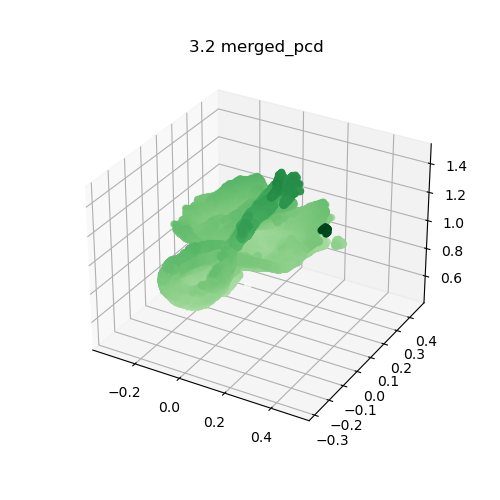

In [57]:
plt_1(merged_pcd_3_2_1, "3.2 merged_pcd")

In [24]:
merged_pcd_3_2_4 = get_merged_pcd_3_2(N=4)

for pcds 0,4: 

#src pts: (4, 67133) #dst pts: (4, 65877)
iteration0: prev_error=0 rms=0.018226924610631853
#src pts: (4, 67133) #dst pts: (4, 65877)
iteration1: prev_error=0.018226924610631853 rms=0.009029730297771212
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration2: prev_error=0.009029730297771212 rms=0.009679989503597553
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration3: prev_error=0.009679989503597553 rms=0.008958203880910684
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration4: prev_error=0.008958203880910684 rms=0.008651066771724792
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration5: prev_error=0.008651066771724792 rms=0.008417057919425383
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration6: prev_error=0.008417057919425383 rms=0.008188767005633089
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration7: prev_error=0.008188767005633089 rms=0.008005459306955015
#src pts: (4, 2238) #dst pts: (4, 2196)
iteration8: prev_error=0.008005459306955015 rms=0.007869145905394288
#src pts: (4, 2238

break at iteration3: prev_error=0.061593700205058034 rms=0.061567584992161264


for pcds 32,36: 

#src pts: (4, 586225) #dst pts: (4, 55678)
iteration0: prev_error=0 rms=0.06277918566251804
#src pts: (4, 586225) #dst pts: (4, 55678)
iteration1: prev_error=0.06277918566251804 rms=0.061094662703333004
#src pts: (4, 15427) #dst pts: (4, 1466)
iteration2: prev_error=0.061094662703333004 rms=0.06286692396103716
#src pts: (4, 15427) #dst pts: (4, 1466)
break at iteration3: prev_error=0.06286692396103716 rms=0.06284012072406185


for pcds 36,40: 

#src pts: (4, 647338) #dst pts: (4, 59205)
iteration0: prev_error=0 rms=0.06290105574367875
#src pts: (4, 647338) #dst pts: (4, 59205)
iteration1: prev_error=0.06290105574367875 rms=0.062256718842569586
#src pts: (4, 16599) #dst pts: (4, 1519)
iteration2: prev_error=0.062256718842569586 rms=0.06452848046685285
#src pts: (4, 16599) #dst pts: (4, 1519)
break at iteration3: prev_error=0.06452848046685285 rms=0.06448564940596227


for pcds 40,44: 

#src

iteration21: prev_error=0.062051587099547674 rms=0.06113596171967488
#src pts: (4, 23835) #dst pts: (4, 818)
iteration22: prev_error=0.06113596171967488 rms=0.06061476540870745
#src pts: (4, 23835) #dst pts: (4, 818)
iteration23: prev_error=0.06061476540870745 rms=0.060336509048642614
#src pts: (4, 23835) #dst pts: (4, 818)
iteration24: prev_error=0.060336509048642614 rms=0.06017740192901241
#src pts: (4, 23835) #dst pts: (4, 818)
break at iteration25: prev_error=0.06017740192901241 rms=0.060088960952629916


for pcds 80,84: 

#src pts: (4, 1209036) #dst pts: (4, 48245)
iteration0: prev_error=0 rms=0.06587243015372723
#src pts: (4, 1209036) #dst pts: (4, 48245)
iteration1: prev_error=0.06587243015372723 rms=0.06484265249092853
#src pts: (4, 24181) #dst pts: (4, 965)
iteration2: prev_error=0.06484265249092853 rms=0.06657445875320969
#src pts: (4, 24181) #dst pts: (4, 965)
iteration3: prev_error=0.06657445875320969 rms=0.06604769605592004
#src pts: (4, 24181) #dst pts: (4, 965)
iteration

In [25]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_2_4.T)
o3d.visualization.draw_geometries([vis_pcd])

In [22]:
merged_pcd_3_2_10 = get_merged_pcd_3_2(N=10)

for pcds 0,10: 

#src pts: (4, 67133) #dst pts: (4, 59813)
iteration0: prev_error=0 rms=0.046661458963178915
#src pts: (4, 67133) #dst pts: (4, 59813)
iteration1: prev_error=0.046661458963178915 rms=0.019013645276976965
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration2: prev_error=0.019013645276976965 rms=0.017805242792085927
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration3: prev_error=0.017805242792085927 rms=0.01616045437775663
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration4: prev_error=0.01616045437775663 rms=0.015344174638472537
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration5: prev_error=0.015344174638472537 rms=0.014849009230986792
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration6: prev_error=0.014849009230986792 rms=0.014540802426327755
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration7: prev_error=0.014540802426327755 rms=0.014313071782045404
#src pts: (4, 2238) #dst pts: (4, 1994)
iteration8: prev_error=0.014313071782045404 rms=0.014139792279522658
#src pts: (4, 2238)

#src pts: (4, 14144) #dst pts: (4, 1083)
iteration6: prev_error=0.07228908529005464 rms=0.07210761529769966
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration7: prev_error=0.07210761529769966 rms=0.0719519706765735
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration8: prev_error=0.0719519706765735 rms=0.07180355079900326
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration9: prev_error=0.07180355079900326 rms=0.07167227159817043
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration10: prev_error=0.07167227159817043 rms=0.07153553682991143
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration11: prev_error=0.07153553682991143 rms=0.07137929084735954
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration12: prev_error=0.07137929084735954 rms=0.07119920227764243
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration13: prev_error=0.07119920227764243 rms=0.07101177392582309
#src pts: (4, 14144) #dst pts: (4, 1083)
iteration14: prev_error=0.07101177392582309 rms=0.07080913080691889
#src pts: (4, 14144) #dst

In [23]:
vis_pcd = o3d.geometry.PointCloud()
vis_pcd.points = o3d.utility.Vector3dVector(merged_pcd_3_2_10.T)
o3d.visualization.draw_geometries([vis_pcd])